<a href="https://colab.research.google.com/github/efonda/Prediction_extreme_events_in_turbulence/blob/master/Prediction_extreme_events_in_turbulence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of extreme events in turbulence

Hypothesis: there are precursor patterns of extreme events in turbulence.
Convolutional neural networks (CNN) are very good at recognizing patterns in images.
Can a CNN predict extreme events in turbulence?

We studied homogeneous isotropic turbuelnce using a DNS psuedospectral method for box size of 512^3.
The quantity that we investigate to study the extreme events is the entrophy $\Omega = \omega_i \omega_i$ where $\omega$ is the vorticity. We then normalized by values by the mean value in the whole box.

In [0]:
import os
import copy
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from sklearn.metrics import roc_curve, auc, confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
!pip install PyDrive

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '18Y0EBcDoqzZHSvkH5bUWs9TSJ6rS'})
download.GetContentFile('ENST1')

In [0]:
download = drive.CreateFile({'id': '1Bmxj82V1_Na0Jug7WXX42NhbnD_n'})
download.GetContentFile('ENST10')

In [0]:
def open_enstrophy(filename,verbose):    
    enstrophy_linear = np.fromfile(filename, dtype = np.dtype('>f4'))
    size = 512
    end_file = size**3
    enstrophy_linear = enstrophy_linear[1:end_file+1]
  
    enstrophy = np.reshape(enstrophy_linear,(size,size,size)) 
    enstrophy = enstrophy/np.mean(enstrophy)
    
    print('mean',np.mean(enstrophy_linear))
    print('rescaled max', enstrophy.max())
    if verbose ==1:
        print('rescaled std',enstrophy.std())
        print(enstrophy_linear)
        print(np.sum(np.power(enstrophy_linear,2))/end_file)
        print(np.sum(np.power(enstrophy_linear,3))/end_file)
        print(np.sum(np.power(enstrophy_linear,4))/end_file)
        print(np.sum(np.power(enstrophy_linear,5))/end_file)
        print(np.sum(np.power(enstrophy_linear,6))/end_file) 
    return enstrophy

In [0]:
def extreme_events(enstrophy,threshold,verbose):
    enstrophy_x = copy.copy(enstrophy)
    size = enstrophy.shape[0]
    end_file = size**3
    low_values_indices = enstrophy_x < (threshold)  # Where values are low

    enstrophy_x[low_values_indices] = 0
    
    x_x = np.where(enstrophy_x>0)[1]
    y_x = np.where(enstrophy_x>0)[2]
    z_x = np.where(enstrophy_x>0)[0]
    array = np.dstack((x_x,y_x,z_x,np.zeros(x_x.size, dtype=np.int)))[0]
    
    start_time = time.time()
    rng = len(array)
    for i in range(rng):
        if (array[i,3] ==0): array[i,3] = 2
        for j in range(i+1,rng):
            if (abs(array[j,2]-array[i,2]<5) and abs(array[j,1]-array[i,1])<5 
                and abs(array[j,0]-array[i,0])<5): array[j,3] = 1
            else : continue 
    
    df = pd.DataFrame(array,columns = ['x','y','z','duplicate'])
    df = df[df['duplicate'] == 2]
    del df['duplicate']
    array
    if verbose == 1:
        elapsed_time = time.time() - start_time
        print('Number of datapoints above',threshold,'times the mean:',end_file - np.sum(low_values_indices))
        print(100*(end_file - np.sum(low_values_indices))/end_file, "%")
        print('elapsed_time', elapsed_time,'s')
        print('number of extreme events:',df.shape[0]) 
    return df   

In [8]:
filename_1 = "ENST1"
enstrophy_1 = open_enstrophy(filename_1,1)

mean 1074.7391
rescaled max 324.5488
rescaled std 2.249532
[123.83703   91.58533   73.08951  ...  50.70482   49.741013  49.84231 ]
7000149.5
176577363968.0
1.1291709539352576e+16
1.3107480424857207e+21
2.2003927501186555e+26


In [9]:
filename_2 = "ENST10"
enstrophy_2 = open_enstrophy(filename_2,1)

mean 1077.4281
rescaled max 587.04694
rescaled std 2.2544618
[ 39.934963  59.27081   62.24726  ... 157.4422   174.77126  157.43317 ]
7061008.0
200148746240.0
2.1222028262506496e+16
5.82176214295524e+21
2.3927040046903094e+27


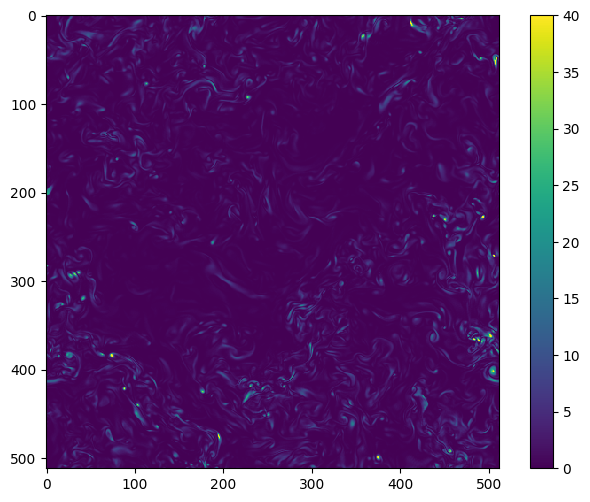

In [10]:
im = plt.figure(figsize=(8, 6), dpi=100)
im = plt.imshow(enstrophy_1[1,:,:], vmin=0, vmax=40)
plt.colorbar(im)
plt.show()

In [0]:
extreme_threshold = 90
df = extreme_events(enstrophy_2,extreme_threshold,1)
df.head(10)

Number of datapoints above 90 times the mean: 2201
0.0016398727893829346 %
elapsed_time 2.7351491451263428 s
number of extreme events: 208


,x,y,z
0,388,485,7
16,423,488,31
19,463,480,38
44,263,496,62
45,316,489,75
47,50,206,79
48,124,102,89
61,427,36,90
68,78,122,93
69,24,130,94


In [0]:
image_size = 28
border = image_size//2
border2 = 6
size = enstrophy_2.shape[0]
print(df.shape)
dftt = df#.head(70)#iloc[555:577]##iloc[0:25]#[4*128:5*128]
dftt = dftt[dftt['x']>border+border2]
dftt = dftt[dftt['y']>border+border2]
dftt = dftt[dftt['z']>border+border2]
dftt = dftt[dftt['x']<size-border-border2]
dftt = dftt[dftt['y']<size-border-border2]
dftt = dftt[dftt['z']<size-border-border2]
print(dftt.shape)

(208, 3)
(140, 3)


In [0]:
def flip_rotate(img):
    return (img, np.rot90(img,1), np.rot90(img,2), np.rot90(img,3), np.flipud(img), 
            np.rot90(np.flipud(img),1), np.rot90(np.flipud(img),2), np.rot90(np.flipud(img),3))

In [0]:
def reshape(imgs):
    imgs_reshaped = np.zeros((imgs.shape[2],imgs.shape[0],imgs.shape[1]))
    for i in range(imgs.shape[2]):
        imgs_reshaped[i,:,:] = imgs[:, :,i]        
    return imgs_reshaped

In [0]:
def images_extreme_events(enstrophy,locations,side):
    dftt = locations    
    aug = 2*3*5*3*8
    imgs = np.zeros((28,28,dftt.shape[0] * aug))
    db = 6
    for i in range(dftt.shape[0]):

        x = dftt.iloc[i]['x']
        y = dftt.iloc[i]['y']
        z = dftt.iloc[i]['z']
#         side = 15 # <<---
        sides = [-side,side]

        for c,t in enumerate(sides):
            for b,s in enumerate([0,-1,1]):
                add = 120*c+40*b+aug*i

                imgz = enstrophy[z+s+t,x-border:x+border,y-border:y+border]  
                (imgs[:,:,0+add],imgs[:,:,1+add],imgs[:,:,2+add],
                 imgs[:,:,3+add],imgs[:,:,4+add], imgs[:,:,5+add],
                 imgs[:,:,6+add],imgs[:,:,7+add]) = flip_rotate(imgz)

                imgzmm = enstrophy[z+s+t,x-border-db:x+border-db,y-border-db:y+border-db] 
                (imgs[:,:,8+add],imgs[:,:,9+add],imgs[:,:,10+add],
                 imgs[:,:,11+add],imgs[:,:,12+add],imgs[:,:,13+add],
                 imgs[:,:,14+add],imgs[:,:,15+add]) = flip_rotate(imgzmm)

                imgzpp = enstrophy[z+s+t,x-border+db:x+border+db,y-border+db:y+border+db] 
                (imgs[:,:,16+add],imgs[:,:,17+add],imgs[:,:,18+add],
                 imgs[:,:,19+add],imgs[:,:,20+add],imgs[:,:,21+add],
                 imgs[:,:,22+add],imgs[:,:,23+add]) = flip_rotate(imgzpp)

                imgzpm = enstrophy[z+s+t,x-border+db:x+border+db,y-border-db:y+border-db]
                (imgs[:,:,24+add],imgs[:,:,25+add],imgs[:,:,26+add],
                 imgs[:,:,27+add],imgs[:,:,28+add],imgs[:,:,29+add],
                 imgs[:,:,30+add],imgs[:,:,31+add]) = flip_rotate(imgzpm)

                imgzmp = enstrophy[z+s+t,x-border-db:x+border-db,y-border+db:y+border+db]
                (imgs[:,:,32+add],imgs[:,:,33+add],imgs[:,:,34+add],
                 imgs[:,:,35+add],imgs[:,:,36+add],imgs[:,:,37+add],
                 imgs[:,:,38+add],imgs[:,:,39+add]) = flip_rotate(imgzmp)  


        for c,t in enumerate(sides):
            for b,s in enumerate([0,-1,1]):
                add = 120+120*c+40*b+aug*i

                imgy = enstrophy[z-border:z+border,x-border:x+border,y+s+t]
                (imgs[:,:,120+add],imgs[:,:,121+add],imgs[:,:,122+add],
                 imgs[:,:,123+add],imgs[:,:,124+add],imgs[:,:,125+add],
                 imgs[:,:,126+add],imgs[:,:,127+add]) = flip_rotate(imgy)

                imgymm = enstrophy[z-border-db:z+border-db,x-border-db:x+border-db,y+s+t]
                (imgs[:,:,128+add],imgs[:,:,129+add],imgs[:,:,130+add],
                 imgs[:,:,131+add],imgs[:,:,132+add],imgs[:,:,133+add],
                 imgs[:,:,134+add],imgs[:,:,135+add]) = flip_rotate(imgymm)     

                imgypp = enstrophy[z-border+db:z+border+db,x-border+db:x+border+db,y+s+t]
                (imgs[:,:,136+add],imgs[:,:,137+add],imgs[:,:,138+add],
                 imgs[:,:,139+add],imgs[:,:,140+add],imgs[:,:,141+add],
                 imgs[:,:,142+add],imgs[:,:,143+add]) = flip_rotate(imgypp)     

                imgypm = enstrophy[z-border+db:z+border+db,x-border-db:x+border-db,y+s+t]
                (imgs[:,:,144+add],imgs[:,:,145+add],imgs[:,:,146+add],
                 imgs[:,:,147+add],imgs[:,:,148+add],imgs[:,:,149+add],
                 imgs[:,:,150+add],imgs[:,:,151+add]) = flip_rotate(imgypm)  

                imgymp = enstrophy[z-border-db:z+border-db,x-border+db:x+border+db,y+s+t]
                (imgs[:,:,152+add],imgs[:,:,153+add],imgs[:,:,154+add],
                 imgs[:,:,155+add],imgs[:,:,156+add],imgs[:,:,157+add],
                 imgs[:,:,158+add],imgs[:,:,159+add]) = flip_rotate(imgymp) 


        for c,t in enumerate(sides):        
            for b,s in enumerate([0,-1,1]):    
                add = 240+120*c+40*b+aug*i

                imgx = enstrophy[z-border:z+border,x+s+t,y-border:y+border]
                (imgs[:,:,240+add],imgs[:,:,241+add],imgs[:,:,242+add],
                 imgs[:,:,243+add],imgs[:,:,244+add],imgs[:,:,245+add],
                 imgs[:,:,246+add],imgs[:,:,247+add]) = flip_rotate(imgx)  

                imgxmm = enstrophy[z-border-db:z+border-db,x+s+t,y-border-db:y+border-db]
                (imgs[:,:,248+add],imgs[:,:,249+add],imgs[:,:,250+add],
                 imgs[:,:,251+add],imgs[:,:,252+add],imgs[:,:,253+add],
                 imgs[:,:,254+add],imgs[:,:,255+add]) = flip_rotate(imgxmm) 

                imgxpp = enstrophy[z-border+db:z+border+db,x+s+t,y-border+db:y+border+db]
                (imgs[:,:,256+add],imgs[:,:,257+add],imgs[:,:,258+add],
                 imgs[:,:,259+add],imgs[:,:,260+add],imgs[:,:,261+add],
                 imgs[:,:,262+add],imgs[:,:,263+add]) = flip_rotate(imgxpp)   

                imgxpm = enstrophy[z-border+db:z+border+db,x+s+t,y-border-db:y+border-db]
                (imgs[:,:,264+add],imgs[:,:,265+add],imgs[:,:,266+add],
                 imgs[:,:,267+add],imgs[:,:,268+add],imgs[:,:,269+add],
                 imgs[:,:,270+add],imgs[:,:,271+add]) = flip_rotate(imgxpm) 

                imgxmp = enstrophy[z-border-db:z+border-db,x+s+t,y-border+db:y+border+db]  
                (imgs[:,:,272+add],imgs[:,:,273+add],imgs[:,:,274+add],
                 imgs[:,:,275+add],imgs[:,:,276+add],imgs[:,:,277+add],
                 imgs[:,:,278+add],imgs[:,:,279+add]) = flip_rotate(imgxmp)
                
    imgs_reshaped = reshape(imgs)
    print(imgs_reshaped.shape)
    imgs_deep = np.zeros((imgs_reshaped.shape[0]//3,28,28,3))
    for m in range(imgs_reshaped.shape[0]//120):
            for i in range(40):
                add1 = m*40
                add2 = m*120
                imgs_deep[i+add1,:,:,1] = imgs_reshaped[i+add2,:,:]
                imgs_deep[i+add1,:,:,0] = imgs_reshaped[i+add2+40,:,:]
                imgs_deep[i+add1,:,:,2] = imgs_reshaped[i+add2+80,:,:] 
    print(imgs_deep.shape) 
    
    return imgs_deep

In [0]:
def images_extreme_events_border(enstrophy,locations,side):

    border = image_size//2
    border2 = 6
    db = 6
    sides = [-side,side]
    size = enstrophy.shape[0]
    
    df = locations

    dfnx = df
    dfnx = dfnx[dfnx['y']>border+border2]
    dfnx = dfnx[dfnx['z']>border+border2]
    dfnx = dfnx[dfnx['y']<size-border-border2]
    dfnx = dfnx[dfnx['z']<size-border-border2]
    dfnx = dfnx[(dfnx['x']<border+border2) | (dfnx['x']> size-border-border2)]
    dfnx = dfnx[(dfnx['x']>side) & (dfnx['x']<size-1-side)]
    print(dfnx.shape)

    dfny = df
    dfny = dfny[dfny['x']>border+border2]
    dfny = dfny[dfny['z']>border+border2]
    dfny = dfny[dfny['x']<size-border-border2]
    dfny = dfny[dfny['z']<size-border-border2]
    dfny = dfny[(dfny['y']<border+border2) | (dfny['y']> size-border-border2)]
    dfny = dfny[(dfny['y']>side) & (dfny['y']<size-1-side)]
    print(dfny.shape)

    dfnz = df
    dfnz = dfnz[dfnz['x']>border+border2]
    dfnz = dfnz[dfnz['y']>border+border2]
    dfnz = dfnz[dfnz['x']<size-border-border2-10]
    dfnz = dfnz[dfnz['y']<size-border-border2]
    dfnz = dfnz[(dfnz['z']<border+border2) | (dfnz['z']> size-border-border2)]
    dfnz = dfnz[(dfnz['z']>side) & (dfnz['z']<size-1-side)]
    print(dfnz.shape)

    imgst = np.zeros((28,28,(dfnx.shape[0]+dfny.shape[0]+dfnz.shape[0])*240))

    for i in range(dfnx.shape[0]):
        x = dfnx.iloc[i]['x']
        y = dfnx.iloc[i]['y']
        z = dfnx.iloc[i]['z']

        for c,t in enumerate(sides):
            for b,s in enumerate([0,-1,1]):
                add = 40*b+120*c+240*i

                imgx = enstrophy[z-border:z+border,x+s+t,y-border:y+border]
                (imgst[:,:,0+add],imgst[:,:,1+add],imgst[:,:,2+add],
                 imgst[:,:,3+add],imgst[:,:,4+add],imgst[:,:,5+add],
                 imgst[:,:,6+add],imgst[:,:,7+add]) = flip_rotate(imgx)  

                imgxmm = enstrophy[z-border-db:z+border-db,x+s+t,y-border-db:y+border-db]
                (imgst[:,:,8+add],imgst[:,:,9+add],imgst[:,:,10+add],
                 imgst[:,:,11+add],imgst[:,:,12+add],imgst[:,:,13+add],
                 imgst[:,:,14+add],imgst[:,:,15+add]) = flip_rotate(imgxmm) 

                imgxpp = enstrophy[z-border+db:z+border+db,x+s+t,y-border+db:y+border+db]
                (imgst[:,:,16+add],imgst[:,:,17+add],imgst[:,:,18+add],
                 imgst[:,:,19+add],imgst[:,:,20+add],imgst[:,:,21+add],
                 imgst[:,:,22+add],imgst[:,:,23+add]) = flip_rotate(imgxpp)   

                imgxpm = enstrophy[z-border+db:z+border+db,x+s+t,y-border-db:y+border-db]
                (imgst[:,:,24+add],imgst[:,:,25+add],imgst[:,:,26+add],
                 imgst[:,:,27+add],imgst[:,:,28+add],imgst[:,:,29+add],
                 imgst[:,:,30+add],imgst[:,:,31+add]) = flip_rotate(imgxpm) 

                imgxmp = enstrophy[z-border-db:z+border-db,x+s+t,y-border+db:y+border+db]  
                (imgst[:,:,32+add],imgst[:,:,33+add],imgst[:,:,34+add],
                 imgst[:,:,35+add],imgst[:,:,36+add],imgst[:,:,37+add],
                 imgst[:,:,38+add],imgst[:,:,39+add]) = flip_rotate(imgxmp) 

    print(add,i)

    for j in range(dfny.shape[0]):

        x = dfny.iloc[j]['x']
        y = dfny.iloc[j]['y']
        z = dfny.iloc[j]['z']

        for c,t in enumerate(sides):
            for b,s in enumerate([0,-1,1]):
    #             add = 120*(i+1)+40*b+120*c+240*j
                add = 40+40*2+120*1+240*i+40*b+120*c+240*j
                add = 240*(i+j)+120*(c+1)+40*(b+3)

                imgx = enstrophy[z-border:z+border,x-border:x+border,y+s+t]
                (imgst[:,:,0+add],imgst[:,:,1+add],imgst[:,:,2+add],
                 imgst[:,:,3+add],imgst[:,:,4+add],imgst[:,:,5+add],
                 imgst[:,:,6+add],imgst[:,:,7+add]) = flip_rotate(imgx)  

                imgxmm = enstrophy[z-border-db:z+border-db,x-border-db:x+border-db,y+s+t]
                (imgst[:,:,8+add],imgst[:,:,9+add],imgst[:,:,10+add],
                 imgst[:,:,11+add],imgst[:,:,12+add],imgst[:,:,13+add],
                 imgst[:,:,14+add],imgst[:,:,15+add]) = flip_rotate(imgxmm) 

                imgxpp = enstrophy[z-border+db:z+border+db,x-border+db:x+border+db,y+s+t]
                (imgst[:,:,16+add],imgst[:,:,17+add],imgst[:,:,18+add],
                 imgst[:,:,19+add],imgst[:,:,20+add],imgst[:,:,21+add],
                 imgst[:,:,22+add],imgst[:,:,23+add]) = flip_rotate(imgxpp)   

                imgxpm = enstrophy[z-border+db:z+border+db,x-border-db:x+border-db,y+s+t]
                (imgst[:,:,24+add],imgst[:,:,25+add],imgst[:,:,26+add],
                 imgst[:,:,27+add],imgst[:,:,28+add],imgst[:,:,29+add],
                 imgst[:,:,30+add],imgst[:,:,31+add]) = flip_rotate(imgxpm) 

                imgxmp = enstrophy[z-border-db:z+border-db,x-border+db:x+border+db,y+s+t]  
                (imgst[:,:,32+add],imgst[:,:,33+add],imgst[:,:,34+add],
                 imgst[:,:,35+add],imgst[:,:,36+add], imgst[:,:,37+add],
                 imgst[:,:,38+add],imgst[:,:,39+add]) = flip_rotate(imgxmp) 



    for k in range(dfnz.shape[0]):

        x = dfnz.iloc[k]['x']
        y = dfnz.iloc[k]['y']
        z = dfnz.iloc[k]['z']

        for c,t in enumerate(sides):
            for b,s in enumerate([0,-1,1]):
                add = 120*(i+2)+120*j+40*b+120*c+240*k
                add = 40+40*2+120*1+240*i+40+40*2+120*1+240*j+40*b+120*c+240*k
                add = 240*(i+j+k)+40*(b+6)+120*(c+2)

                imgx = enstrophy[z+s+t,x-border:x+border,y-border:y+border]
                (imgst[:,:,0+add],imgst[:,:,1+add],imgst[:,:,2+add],
                 imgst[:,:,3+add], imgst[:,:,4+add],imgst[:,:,5+add],
                 imgst[:,:,6+add],imgst[:,:,7+add]) = flip_rotate(imgx)  

                imgxmm = enstrophy[z+s+t,x-border-db:x+border-db,y-border-db:y+border-db]
                (imgst[:,:,8+add],imgst[:,:,9+add],imgst[:,:,10+add],
                 imgst[:,:,11+add],imgst[:,:,12+add],imgst[:,:,13+add],
                 imgst[:,:,14+add],imgst[:,:,15+add]) = flip_rotate(imgxmm) 

                imgxpp = enstrophy[z+s+t,x-border+db:x+border+db,y-border+db:y+border+db]
                (imgst[:,:,16+add],imgst[:,:,17+add],imgst[:,:,18+add],
                 imgst[:,:,19+add],imgst[:,:,20+add],imgst[:,:,21+add],
                 imgst[:,:,22+add],imgst[:,:,23+add]) = flip_rotate(imgxpp)   

                imgxpm = enstrophy[z+s+t,x-border-db:x+border-db,y-border+db:y+border+db]
                (imgst[:,:,24+add],imgst[:,:,25+add],imgst[:,:,26+add],
                 imgst[:,:,27+add],imgst[:,:,28+add],imgst[:,:,29+add],
                 imgst[:,:,30+add],imgst[:,:,31+add]) = flip_rotate(imgxpm) 

                imgxmp = enstrophy[z+s+t,x-border+db:x+border+db,y-border-db:y+border-db]  
                (imgst[:,:,32+add],imgst[:,:,33+add],imgst[:,:,34+add],
                 imgst[:,:,35+add],imgst[:,:,36+add],imgst[:,:,37+add],
                 imgst[:,:,38+add],imgst[:,:,39+add]) = flip_rotate(imgxmp) 


    print(imgst.shape)


    imgst_reshaped = reshape(imgst)
    print(imgst_reshaped.shape)

    imgst_deep = np.zeros((imgst_reshaped.shape[0]//3,28,28,3))
    for m in range(imgst_reshaped.shape[0]//120):
            for i in range(40):
                add1 = m*40
                add2 = m*120
                imgst_deep[i+add1,:,:,1] = imgst_reshaped[i+add2,:,:]
                imgst_deep[i+add1,:,:,0] = imgst_reshaped[i+add2+40,:,:]
                imgst_deep[i+add1,:,:,2] = imgst_reshaped[i+add2+80,:,:]
    
    return imgst_deep

In [0]:
side = 0
imgs_deep = images_extreme_events(enstrophy_1,dftt,side)

(100800, 28, 28)
(33600, 28, 28, 3)


In [0]:
imgs_deep_cont = images_extreme_events(enstrophy_2,dftt,side)

(100800, 28, 28)
(33600, 28, 28, 3)


In [0]:
imgst_deep = images_extreme_events_border(enstrophy_1,df,side)

(15, 3)
(39, 3)
(2, 3)
3560 14
(28, 28, 13440)
(13440, 28, 28)


In [0]:
# # Remove extreme events from training set
# count = 0
# x = []
# for i in range(imgs_deep.shape[0]):    
#     if np.max(imgs_deep[i,:,:,:])>extreme_threshold:      
#         x.append(count)
#     count+=1    
# print(count)
# # print(x)
# imgs_deep = np.delete(imgs_deep,x, axis=0)
# print(imgs_deep.shape)

In [0]:
# # Remove extreme events from test set
# count = 0
# x = []
# for i in range(imgst_deep.shape[0]):    
#     if np.max(imgst_deep[i,:,:,:])>extreme_threshold:      
#         x.append(count)
#     count+=1    
# print(count)
# # print(x)
# imgst_deep = np.delete(imgst_deep,x, axis=0)
# print(imgst_deep.shape)

In [0]:
multiples = 24*3
number_random_deep_no_augm = 6*(imgs_deep.shape[0]+imgst_deep.shape[0])//multiples
np.random.seed(seed=137) # 137
rand = np.random.randint(border+border2,size-border-border2, size=(number_random_deep_no_augm,3))

dfne = pd.DataFrame(rand,columns=['x','y','z'])

imgsn = np.zeros((28,28,dfne.shape[0]*multiples))

for i in range(dfne.shape[0]):
    x = dfne.iloc[i]['x']
    y = dfne.iloc[i]['y']
    z = dfne.iloc[i]['z']
    
    for b,s in enumerate([0,1,-1]):
        add = b*24+multiples*i
        
        imgx = enstrophy_1[z+s,x-border:x+border,y-border:y+border]
        (imgsn[:,:,0+add],imgsn[:,:,1+add],imgsn[:,:,2+add],
         imgsn[:,:,3+add],imgsn[:,:,4+add],imgsn[:,:,5+add],
         imgsn[:,:,6+add],imgsn[:,:,7+add]) = flip_rotate(imgx)  

        imgx = enstrophy_1[z-border:z+border,x+s,y-border:y+border]
        (imgsn[:,:,8+add],imgsn[:,:,9+add],imgsn[:,:,10+add],
         imgsn[:,:,11+add],imgsn[:,:,12+add],imgsn[:,:,13+add],
         imgsn[:,:,14+add],imgsn[:,:,15+add]) = flip_rotate(imgx)  

        imgx = enstrophy_1[z-border:z+border,x-border:x+border,y+s]
        (imgsn[:,:,16+add],imgsn[:,:,17+add],imgsn[:,:,18+add],
         imgsn[:,:,19+add],imgsn[:,:,20+add],imgsn[:,:,21+add],
         imgsn[:,:,22+add],imgsn[:,:,23+add]) = flip_rotate(imgx)

In [0]:
imgsn.shape

(28, 28, 228456)

In [0]:
imgsn_reshaped = reshape(imgsn)
imgsn_reshaped.shape
imgsn_deep = np.zeros((imgsn_reshaped.shape[0]//3,28,28,3))
for j in range(imgsn_reshaped.shape[0]//72):
        for i in range(24):
            imgsn_deep[i+j*24,:,:,1] = imgsn_reshaped[i+j*72,:,:]
            imgsn_deep[i+j*24,:,:,0] = imgsn_reshaped[i+j*72+24,:,:]
            imgsn_deep[i+j*24,:,:,2] = imgsn_reshaped[i+j*72+48,:,:]

In [0]:
print(imgsn_deep.shape)
print(imgsn_deep.max())

(76152, 28, 28, 3)
223.7930145263672


In [0]:
print(imgsn_deep.shape)
print(imgsn_deep.max())

idx = []
for i in range(imgsn_deep.shape[0]):
    if np.any(imgsn_deep[i,:,:,:]>extreme_threshold):
        idx.append(i)
imgsns_deep = np.delete(imgsn_deep,idx,0)
print(imgsns_deep.shape)
print(imgsns_deep.max())

(76152, 28, 28, 3)
223.7930145263672
(75632, 28, 28, 3)
88.43034362792969


In [0]:
print(imgs_deep.shape)
print(imgst_deep.shape)
print(imgsns_deep.shape)
train_dataset_deep = np.concatenate((imgs_deep,imgsns_deep[:imgs_deep.shape[0],:,:,:]), axis=0)
test_dataset_deep = np.concatenate((imgst_deep,imgsns_deep[imgs_deep.shape[0]:imgs_deep.shape[0]+imgst_deep.shape[0],:,:,:]), axis=0)
train_labels_deep = np.zeros(train_dataset_deep.shape[0])
train_labels_deep[:imgs_deep.shape[0]] = 1
test_labels_deep = np.zeros(test_dataset_deep.shape[0])
test_labels_deep[:imgst_deep.shape[0]] = 1
print(train_dataset_deep.shape)
print(test_dataset_deep.shape)
print(train_labels_deep.shape)
print(test_labels_deep.shape)

(33600, 28, 28, 3)
(4480, 28, 28, 3)
(75632, 28, 28, 3)
(67200, 28, 28, 3)
(8960, 28, 28, 3)
(67200,)
(8960,)


In [0]:
imgs_deep = 0
imgsns_deep = 0

In [0]:
def convnet(X_train,y_train,channels):
    
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(28,28,channels))) #32
    model.add(Conv2D(128, (3, 3), activation='relu')) #64
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu')) #added
    model.add(Flatten())
    model.add(Dense(128, activation='relu')) # 128
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
              optimizer='sgd', # adam, sgd
              metrics=['accuracy'])
    class_weight = {0 : 1.,1: 1.}  
    model.fit(X_train, y_train, 
          batch_size=32, epochs=100, verbose=1,class_weight = class_weight)   
    
    return model

In [0]:
model = convnet(train_dataset_deep,train_labels_deep,3)

Using TensorFlow backend.




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
67200/67200 [==============================] - 35s 521us/step - loss: 0.3585 - acc: 0.8483
Epoch 2/100
67200/67200 [==============================] - 31s 469us/step - loss: 0.3082 - acc: 0.8731
Epoch 3/100
67200/67200 [==============================] - 32s 469us/step - loss: 0.3009 - acc: 0.8772
Epoch 4/100
67200/67200 [==============================] - 31s 468us/step - loss: 0.2941 - acc: 0.8794
Epoch 5/100
67200/67200 [==============================] - 31s 464us/step - loss: 0.2886 - acc: 0.8825
Epoch 6/100
67200/67200 [==============================] - 31s 456us/step - loss: 0.2829 - acc: 0.8843
Epoch 7/100
67200/67200 [==============================] - 30s 453us/step - loss: 0.2780 - acc: 0.8858
Epoch 8/100
67200/67200 [==============================] - 31s 454u

In [0]:
predictions = model.predict(test_dataset_deep)

In [0]:
fpr, tpr, _ = roc_curve(test_labels_deep, predictions)
roc_auc = auc(fpr, tpr)
roc_auc

0.9247654257015306

In [0]:
fpr, tpr, _ = roc_curve( test_labels_deep,predictions)
roc_auc = auc(fpr, tpr)
roc_auc

0.9463876155931122

In [0]:
tprt = []
fprt = []
for thr in range(0,200,1):
    threshold = thr/2
    count = 0
    maximum = np.max(test_dataset_deep[:,:,:])
    x = []  
    for i in range(test_dataset_deep.shape[0]):    
        if np.max(test_dataset_deep[i,:,:])>threshold:      
            x.append(1)
        else:
            x.append(0)
        count+=1
    tn, fn, fp, tp = confusion_matrix(x, test_labels_deep).ravel()
    fprt.append(fp/(tp+fn))
    tprt.append(tp/(tn+fp))

In [0]:
roc_auc_t = auc(fprt, tprt)
roc_auc_t

0.9465816326530612

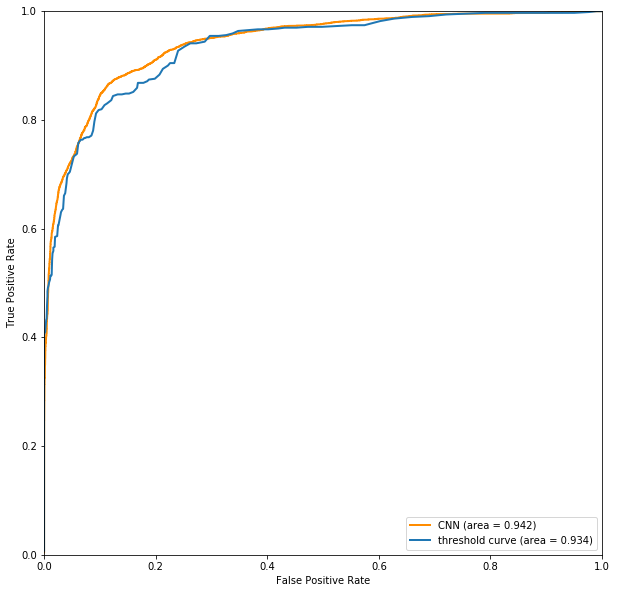

In [0]:
plt.figure(figsize=(10, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='CNN (area = %0.3f)' % roc_auc)
plt.plot(fprt, tprt,  lw=lw, label='threshold curve (area = %0.3f)' % roc_auc_t)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw/2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.00])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

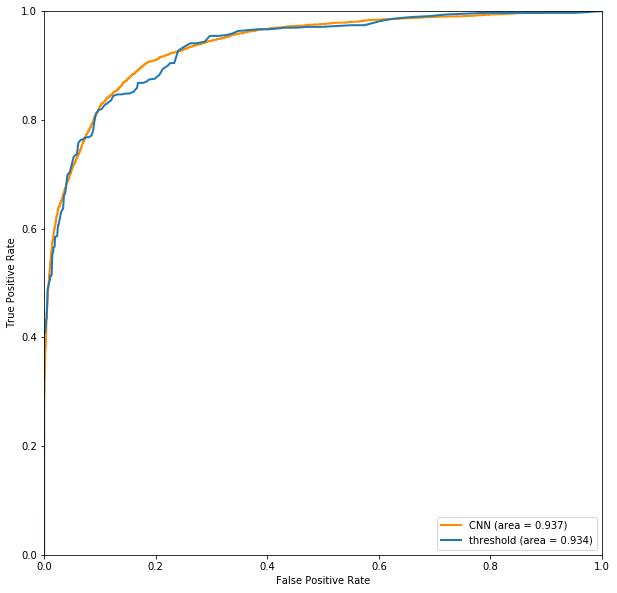

In [0]:
plt.figure(figsize=(10, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='CNN (area = %0.3f)' % roc_auc)
plt.plot(fprt, tprt,  lw=lw, label='threshold (area = %0.3f)' % roc_auc_t)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw/2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.00])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()